# Trading Strategy Optimization: EMA & RSI Indicators
This notebook downloads real stock price data and calculates key trading indicators:
- Exponential Moving Averages (EMA)
- Relative Strength Index (RSI)


In [260]:
import yfinance as yf              # Downloads stock price data
import pandas as pd               # Handles data tables
import matplotlib.pyplot as plt   # For plotting
import numpy as np


## Step 1: Download Historical Stock Data
We'll use yfinance to get daily prices for a selected ticker (e.g., SPY).


In [261]:
# Step 1: Download Historical Stock Data for Multiple Tickers

# List of tickers to analyze
tickers = ["TSLA", "MSTR", "NVDA", "META", "MSFT", "PLNT", "TSM"]

# Dictionary to store price data
stock_data = {}

# Download and store each ticker's data
for ticker in tickers:
    df = yf.download(ticker, start="2022-01-01", end="2024-12-31")
    stock_data[ticker] = df
    print(f"{ticker} downloaded successfully. Rows: {len(df)}")


C:\Users\duelc\AppData\Local\Temp\ipykernel_8568\1915639224.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2022-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
C:\Users\duelc\AppData\Local\Temp\ipykernel_8568\1915639224.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2022-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
C:\Users\duelc\AppData\Local\Temp\ipykernel_8568\1915639224.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2022-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
C:\Users\duelc\AppData\Local\Temp\ipykernel_8568\1915639224.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download

TSLA downloaded successfully. Rows: 752
MSTR downloaded successfully. Rows: 752
NVDA downloaded successfully. Rows: 752
META downloaded successfully. Rows: 752
MSFT downloaded successfully. Rows: 752
PLNT downloaded successfully. Rows: 752
TSM downloaded successfully. Rows: 752


In [262]:
# Choose a ticker to analyze for this run
data = stock_data["TSLA"]  # Or "NVDA", "MSFT", etc.
ticker = "TSLA"

data.columns = data.columns.get_level_values(0)  # Keep only the first level (e.g., 'Close', 'EMA_9')


## Step 2: Calculate Exponential Moving Averages (EMA)
These are trend-following indicators used to detect short- and mid-term market direction.


In [263]:
# 50-day EMA
data["EMA_50"] = data["Close"].ewm(span=21, adjust=False).mean()


## Step 3: Calculate Relative Strength Index (RSI)
RSI is a momentum oscillator that ranges from 0 to 100. Values <30 suggest oversold conditions, >70 suggest overbought.


In [264]:
def compute_rsi(data, window=14):
    delta = data["Close"].diff()               # Price changes between days
    gain = delta.clip(lower=0)                 # Keep gains only
    loss = -1 * delta.clip(upper=0)            # Keep losses only

    avg_gain = gain.rolling(window=window).mean()  # Rolling avg gain
    avg_loss = loss.rolling(window=window).mean()  # Rolling avg loss

    rs = avg_gain / avg_loss                   # Relative strength
    rsi = 100 - (100 / (1 + rs))               # Final RSI formula
    return rsi

# Add RSI column
data["RSI_14"] = compute_rsi(data)


## Step 4: Plot Price and EMAs
This helps us visually assess potential crossover strategies.


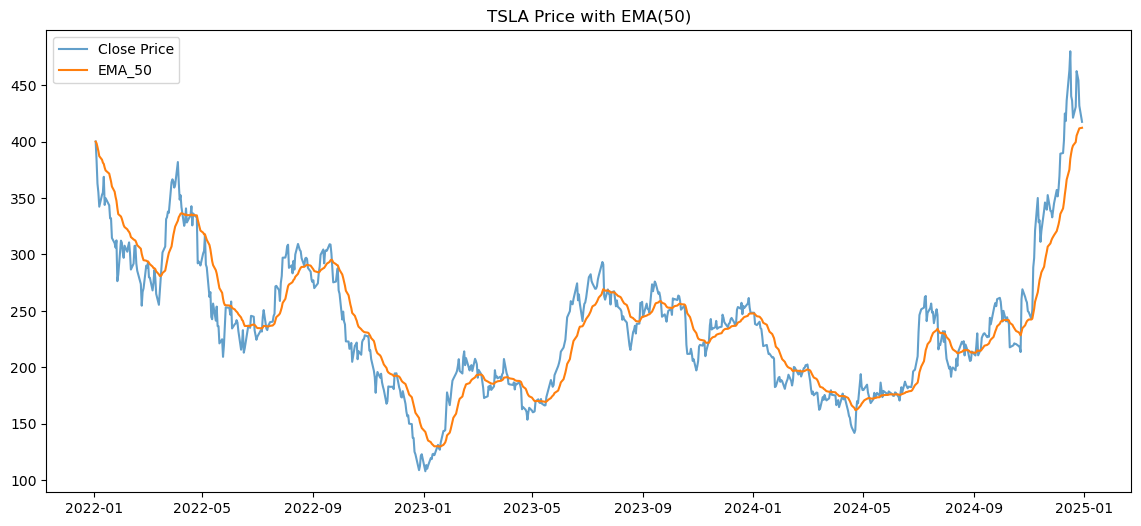

In [265]:
# Set chart size
plt.figure(figsize=(14, 6))

# Plot closing price
plt.plot(data["Close"], label="Close Price", alpha=0.7)

# Plot EMA indicator
plt.plot(data["EMA_50"], label="EMA_50")

# Add chart details
plt.title(f"{ticker} Price with EMA(50)")
plt.legend()
plt.show()


## Step 5 (Optional): Plot RSI Indicator
A secondary chart to spot momentum shifts.


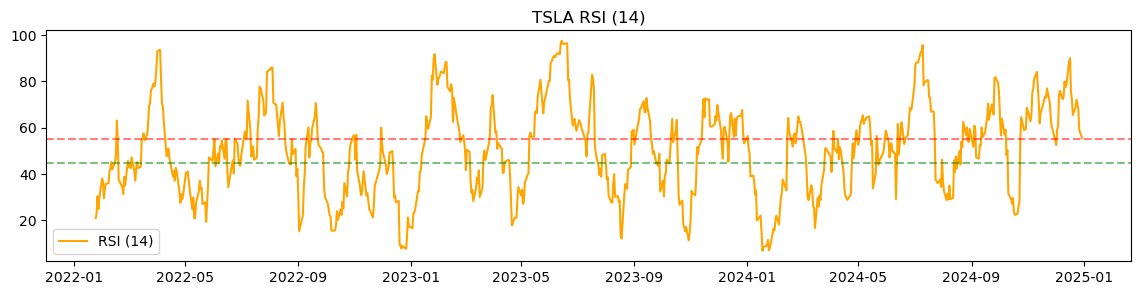

In [266]:
plt.figure(figsize=(14, 3))
plt.plot(data["RSI_14"], label="RSI (14)", color="orange")
plt.axhline(55, linestyle='--', color='red', alpha=0.5)  # Overbought line
plt.axhline(45, linestyle='--', color='green', alpha=0.5)  # Oversold line
plt.title(f"{ticker} RSI (14)")
plt.legend()
plt.show()


In [267]:
# Step 6: Generate Buy and Sell Signals

# Generate New EMA(50) + RSI Signals
ema_period = 50

# Compute 50-day EMA if you haven't already
data[f"EMA_{ema_period}"] = data["Close"].ewm(span=ema_period, adjust=False).mean()

# Buy when price > EMA50 AND RSI > 55
data["Buy_Signal"] = (
    (data["Close"] > data[f"EMA_{ema_period}"]) &
    (data["RSI_14"] > 55)
)

# Sell when price < EMA50 AND RSI < 45
data["Sell_Signal"] = (
    (data["Close"] < data[f"EMA_{ema_period}"]) &
    (data["RSI_14"] < 45)
)


In [268]:
# Confirm the new columns exist and inspect the last few values
print(data[["Close", "EMA_50", "RSI_14", "Buy_Signal", "Sell_Signal"]].tail(10))


Price            Close      EMA_50     RSI_14  Buy_Signal  Sell_Signal
Date                                                                  
2024-12-16  463.019989  325.317671  88.760850        True        False
2024-12-17  479.859985  331.378154  90.010751        True        False
2024-12-18  440.130005  335.642933  75.366650        True        False
2024-12-19  436.170013  339.585171  72.408544        True        False
2024-12-20  421.059998  342.780262  65.507886        True        False
2024-12-23  430.600006  346.224174  68.841618        True        False
2024-12-24  462.279999  350.775383  72.174769        True        False
2024-12-26  454.130005  354.828505  68.250827        True        False
2024-12-27  431.660004  357.841505  59.044415        True        False
2024-12-30  417.410004  360.177525  55.561821        True        False


In [269]:
# Show the first 10 buy signals with their key stats
buys = data.loc[data["Buy_Signal"], ["Close","EMA_50","RSI_14"]].head(10)
print("First 10 Buys:\n", buys)

# And the first 10 sell signals
sells = data.loc[data["Sell_Signal"], ["Close","EMA_50","RSI_14"]].head(10)
print("\nFirst 10 Sells:\n", sells)


First 10 Buys:
 Price            Close      EMA_50     RSI_14
Date                                         
2022-03-21  307.053345  304.733896  57.232375
2022-03-22  331.326660  305.776749  62.679202
2022-03-23  333.036682  306.845766  69.281440
2022-03-24  337.973328  308.066455  70.505546
2022-03-25  336.880005  309.196398  75.898653
2022-03-28  363.946655  311.343467  79.120212
2022-03-29  366.523346  313.507384  77.824041
2022-03-30  364.663330  315.513499  80.638440
2022-03-31  359.200012  317.226696  86.120145
2022-04-01  361.529999  318.964080  93.151992

First 10 Sells:
 Price            Close      EMA_50     RSI_14
Date                                         
2022-01-24  310.000000  375.696177  21.031260
2022-01-25  306.133331  372.968222  22.931734
2022-01-26  312.470001  370.595743  30.406402
2022-01-27  276.366669  366.900485  24.908404
2022-01-28  282.116669  363.575629  29.887074
2022-01-31  312.239990  361.562467  38.055879
2022-02-01  310.416656  359.556749  36.878928


In [270]:
#testing signal fire or not
# How many buy/sell signals do you have?
n_buys  = data["Buy_Signal"].sum()
n_sells = data["Sell_Signal"].sum()
print(f"Buys: {n_buys}, Sells: {n_sells}")


Buys: 258, Sells: 250


In [271]:
# Step 7: Simulate Trades and Log Results
# --- Rebuild the trades list from scratch ---
trades = []
position = 0
buy_price = None

for i in range(len(data)):
    row = data.iloc[i]
    
    # enter trade
    if bool(row["Buy_Signal"]) and position == 0:
        trades.append({
            "Buy Date":  data.index[i],
            "Ticker":    ticker,
            "Buy Price": row["Close"],
            "Sell Date": None,
            "Sell Price":None,
            "Return (%)":None,
            "Holding Period (days)": None
        })
        position = 1
        buy_price = row["Close"]
    
    # exit trade
    elif bool(row["Sell_Signal"]) and position == 1:
        sell_price = row["Close"]
        sell_date  = data.index[i]
        ret_pct     = (sell_price - buy_price) / buy_price * 100
        duration    = (sell_date - trades[-1]["Buy Date"]).days
        
        # update the last trade dict in the list
        trades[-1].update({
            "Sell Date":            sell_date,
            "Sell Price":           sell_price,
            "Return (%)":           ret_pct,
            "Holding Period (days)":duration
        })
        position = 0
        buy_price = None

# debug print
print("Trades list after simulation:", trades)


Trades list after simulation: [{'Buy Date': Timestamp('2022-03-21 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 307.0533447265625, 'Sell Date': Timestamp('2022-04-20 00:00:00'), 'Sell Price': 325.73333740234375, 'Return (%)': 6.083631068215908, 'Holding Period (days)': 30}, {'Buy Date': Timestamp('2022-07-21 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 271.7066650390625, 'Sell Date': Timestamp('2022-08-30 00:00:00'), 'Sell Price': 277.70001220703125, 'Return (%)': 2.205815292424683, 'Holding Period (days)': 40}, {'Buy Date': Timestamp('2022-09-12 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 304.4200134277344, 'Sell Date': Timestamp('2022-09-29 00:00:00'), 'Sell Price': 268.2099914550781, 'Return (%)': -11.89475736661843, 'Holding Period (days)': 17}, {'Buy Date': Timestamp('2023-01-26 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 160.27000427246094, 'Sell Date': Timestamp('2023-03-08 00:00:00'), 'Sell Price': 182.0, 'Return (%)': 13.55836722297568, 'Holding Period (days)': 41}, {'Buy Date': Time

In [272]:
print("Raw trades list:", trades)


Raw trades list: [{'Buy Date': Timestamp('2022-03-21 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 307.0533447265625, 'Sell Date': Timestamp('2022-04-20 00:00:00'), 'Sell Price': 325.73333740234375, 'Return (%)': 6.083631068215908, 'Holding Period (days)': 30}, {'Buy Date': Timestamp('2022-07-21 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 271.7066650390625, 'Sell Date': Timestamp('2022-08-30 00:00:00'), 'Sell Price': 277.70001220703125, 'Return (%)': 2.205815292424683, 'Holding Period (days)': 40}, {'Buy Date': Timestamp('2022-09-12 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 304.4200134277344, 'Sell Date': Timestamp('2022-09-29 00:00:00'), 'Sell Price': 268.2099914550781, 'Return (%)': -11.89475736661843, 'Holding Period (days)': 17}, {'Buy Date': Timestamp('2023-01-26 00:00:00'), 'Ticker': 'TSLA', 'Buy Price': 160.27000427246094, 'Sell Date': Timestamp('2023-03-08 00:00:00'), 'Sell Price': 182.0, 'Return (%)': 13.55836722297568, 'Holding Period (days)': 41}, {'Buy Date': Timestamp('2023-0

In [273]:
# --- 1) Filter to realized trades only ---
realized = trade_log.dropna(subset=["Sell Date"]).copy()

# --- 2) Basic P/L and counts ---
realized["Profit"] = realized["Sell Price"] - realized["Buy Price"]
realized["Loss"]   = realized["Profit"].clip(upper=0).abs()
realized["Gain"]   = realized["Profit"].clip(lower=0)

# --- 3) Win Rate ---
win_rate = (realized["Profit"] > 0).mean() * 100

# --- 4) Risk-Reward Ratio (avg gain / avg loss) ---
avg_gain = realized["Gain"].mean()
avg_loss = realized["Loss"].mean()
risk_reward = avg_gain / avg_loss if avg_loss != 0 else np.nan

# --- 5) Profit Factor (gross profit / gross loss) ---
gross_profit = realized["Gain"].sum()
gross_loss   = realized["Loss"].sum()
profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan

# --- 6) ROI (% total net P/L vs sum of buys) ---
total_profit = realized["Profit"].sum()
total_cost   = realized["Buy Price"].sum()
roi = total_profit / total_cost * 100

# --- 7) Expectancy (avg profit per trade) ---
expectancy = realized["Profit"].mean()

# --- 8) Equity Curve & CAR/MDD & Sharpe & Sortino & Ulcer ---
eq = (1 + realized["Return (%)"]/100).cumprod()
daily = eq.pct_change().fillna(0)
car = (eq.iloc[-1]**(252/len(eq)) - 1) * 100            # Compound annual return
sharpe = daily.mean()/daily.std()*np.sqrt(252)

# Downside returns for Sortino
neg_returns = daily[daily<0]
sortino = daily.mean()/neg_returns.std()*np.sqrt(252) if len(neg_returns)>1 else np.nan

# Drawdown for Ulcer Index
running_max = eq.cummax()
drawdowns   = (running_max - eq)/running_max
ulcer_index = np.sqrt(np.mean(drawdowns**2)) * 100

# --- 9) Max Drawdown (already) ---
max_dd = drawdowns.max() * 100

# --- 10) CAR/MDD Ratio ---
car_mdd = car / max_dd if max_dd != 0 else np.nan

# --- 11) Assemble Metrics Table ---
metrics = pd.DataFrame([
    ["Win Rate (%)",           "% of profitable trades",                  win_rate],
    ["Risk-Reward Ratio",      "Avg gain vs avg loss per trade",         risk_reward],
    ["Profit Factor",          "Gross profit / gross loss",              profit_factor],
    ["ROI (%)",                "% net profit vs total cost",             roi],
    ["Expectancy",             "Avg profit per trade",                   expectancy],
    ["Sharpe Ratio",           "Risk-adjusted return",                    sharpe],
    ["Sortino Ratio",          "Downside risk-adjusted return",           sortino],
    ["Ulcer Index",            "Drawdown depth & duration",               ulcer_index],
    ["Max Drawdown (%)",       "Largest equity decline",                  max_dd],
    ["CAR/MDD Ratio",          "Annual return vs max drawdown",           car_mdd],
], columns=["Metric","What It Measures","Value"])

# Display both
print("Realized Trades:")  
display(realized.head())
print("\nPerformance Metrics:")
display(metrics)


Realized Trades:


,Ticker,Buy Price,Sell Date,Sell Price,Return (%),Holding Period (days),Profit/Loss,Win,Cumulative_Return,Profit,Loss,Gain
Buy Date,,,,,,,,,,,,
2022-03-21,TSLA,307.053345,2022-04-20,325.733337,6.083631,30.0,6.083631,True,6.083631,18.679993,0.000000,18.679993
2022-07-21,TSLA,271.706665,2022-08-30,277.700012,2.205815,40.0,2.205815,True,8.289446,5.993347,0.000000,5.993347
2022-09-12,TSLA,304.420013,2022-09-29,268.209991,-11.894757,17.0,-11.894757,False,-3.605311,-36.210022,36.210022,0.000000
2023-01-26,TSLA,160.270004,2023-03-08,182.000000,13.558367,41.0,13.558367,True,9.953056,21.729996,0.000000,21.729996
2023-03-28,TSLA,189.190002,2023-04-12,180.539993,-4.572128,15.0,-4.572128,False,5.380928,-8.650009,8.650009,0.000000



Performance Metrics:


,Metric,What It Measures,Value
0,Win Rate (%),% of profitable trades,42.857143
1,Risk-Reward Ratio,Avg gain vs avg loss per trade,0.974693
2,Profit Factor,Gross profit / gross loss,0.974693
3,ROI (%),% net profit vs total cost,-0.113656
4,Expectancy,Avg profit per trade,-0.254048
5,Sharpe Ratio,Risk-adjusted return,0.621271
6,Sortino Ratio,Downside risk-adjusted return,1.680621
7,Ulcer Index,Drawdown depth & duration,19.810327
8,Max Drawdown (%),Largest equity decline,35.573271
9,CAR/MDD Ratio,Annual return vs max drawdown,1.759074


In [274]:
# --- 1) Prepare your realized trades DataFrame ---
realized = trade_log.dropna(subset=["Sell Date"]).copy()

# Reset index so Buy Date is a column again
realized.reset_index(inplace=True)  
# Now realized.columns includes 'Buy Date'

# --- 2) Compute Profit, Gain, Loss ---
realized["Profit"] = realized["Sell Price"] - realized["Buy Price"]
realized["Gain"]   = realized["Profit"].clip(lower=0)
realized["Loss"]   = (-realized["Profit"].clip(upper=0))

# --- 3) (Re)save both sheets to Excel ---
# Make sure you still have your metrics DataFrame in memory
# (from earlier code – e.g. metrics)

with pd.ExcelWriter("strategy_results_full.xlsx", engine="openpyxl") as writer:
    # Realized Trades sheet now has Buy Date, Sell Date, Buy/Sell Price, Profit, Gain, Loss, etc.
    realized.to_excel(writer, sheet_name="Realized Trades", index=False)
    # Performance Metrics sheet
    metrics.to_excel(writer, sheet_name="Performance Metrics", index=False)

print("strategy_results_full.xlsx written with full Realized Trades data.")


strategy_results_full.xlsx written with full Realized Trades data.


In [280]:
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter

# Load the workbook
wb = load_workbook("strategy_results_full.xlsx")
ws = wb["Realized Trades"]

# Map headers
col_map = {cell.value: get_column_letter(cell.column) for cell in ws[1]}

# Format Dates
for field in ["Buy Date", "Sell Date"]:
    col = col_map.get(field)
    if col:
        for row in ws[f"{col}2":f"{col}{ws.max_row}"]:
            for cell in row:
                cell.number_format = "MM/DD/YYYY"

# Format Numeric columns
for field in ["Buy Price","Sell Price","Profit","Gain","Loss","Return (%)"]:
    col = col_map.get(field)
    if col:
        for row in ws[f"{col}2":f"{col}{ws.max_row}"]:
            for cell in row:
                cell.number_format = "#,##0.00"

# Autofit widths
for col_cells in ws.columns:
    max_len = max((len(str(c.value)) for c in col_cells if c.value), default=0)
    ws.column_dimensions[get_column_letter(col_cells[0].column)].width = max_len + 2

# Save
wb.save("strategy_results_formatted.xlsx")
print("strategy_results_formatted.xlsx created with formatting.")


strategy_results_formatted.xlsx created with formatting.


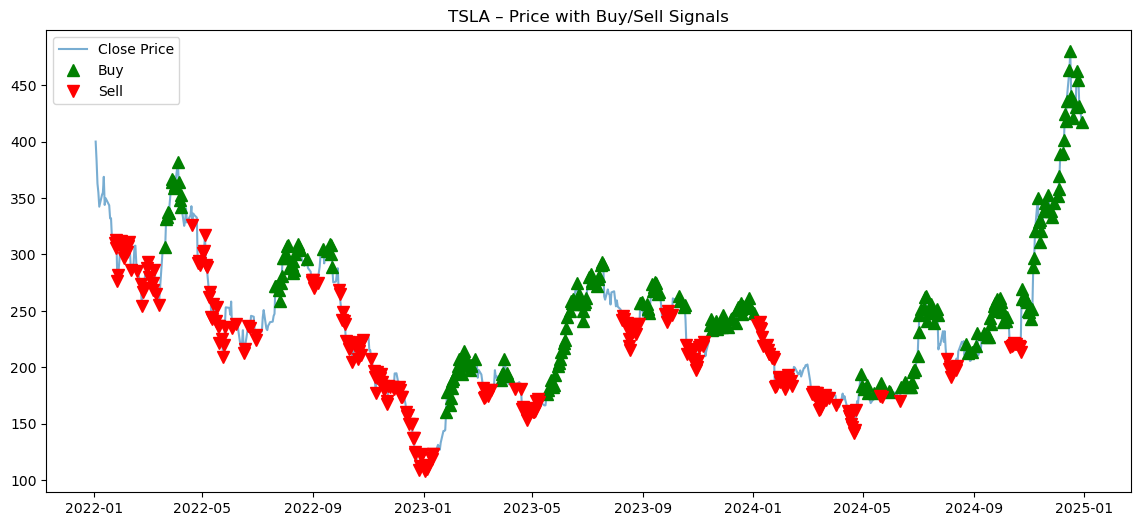

In [276]:
# Step 10: Visualize Buy/Sell on Price Chart
plt.figure(figsize=(14, 6))
plt.plot(data["Close"], label="Close Price", alpha=0.6)
plt.plot(data[data["Buy_Signal"]].index, data[data["Buy_Signal"]]["Close"],
         marker="^", color="green", label="Buy", linestyle="None", markersize=8)
plt.plot(data[data["Sell_Signal"]].index, data[data["Sell_Signal"]]["Close"],
         marker="v", color="red", label="Sell", linestyle="None", markersize=8)
plt.title(f"{ticker} – Price with Buy/Sell Signals")
plt.legend()
plt.show()

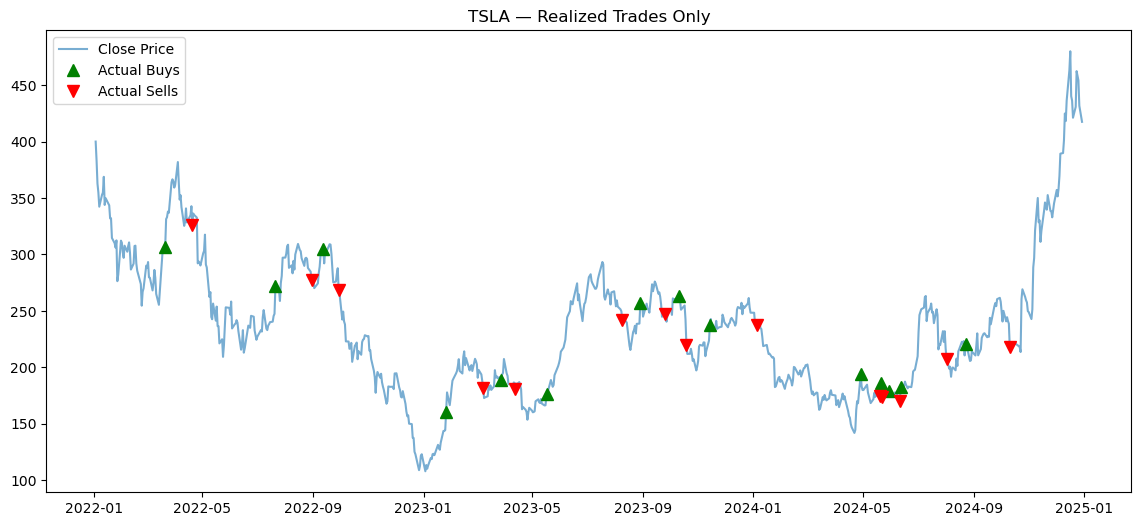

In [277]:
# 1) Filter to only realized trades (no NaT sells)
realized = trade_log.dropna(subset=["Sell Date"]).copy()

# 2) Ensure both Buy and Sell dates are in data.index
buy_dates  = realized.index.intersection(data.index)
sell_dates = realized["Sell Date"][realized["Sell Date"].isin(data.index)]

# 3) Plot price + only those realized trades
plt.figure(figsize=(14,6))
plt.plot(data["Close"], label="Close Price", alpha=0.6)

# Actual Buys
plt.plot(
    buy_dates,
    data.loc[buy_dates, "Close"],
    "^", color="green", label="Actual Buys", markersize=8
)

# Actual Sells
plt.plot(
    sell_dates,
    data.loc[sell_dates, "Close"],
    "v", color="red", label="Actual Sells", markersize=8
)

plt.title(f"{ticker} — Realized Trades Only")
plt.legend()
plt.show()


In [278]:
# Load without parsing dates
df = pd.read_csv("realized_trades.csv")
print(df.columns.tolist())


['Ticker', 'Buy Price', 'Sell Date', 'Sell Price', 'Return (%)', 'Holding Period (days)', 'Profit/Loss', 'Win', 'Cumulative_Return']


In [279]:
# Step 11: Export to Excel
with pd.ExcelWriter(f"{ticker}_trades.xlsx", engine='openpyxl') as writer:
    # Export Trade_Log with datetime index and Sell Date
    trade_log_with_dates = trade_log.copy()
    trade_log_with_dates.index = pd.to_datetime(trade_log_with_dates.index)
    if "Sell Date" in trade_log_with_dates.columns:
        trade_log_with_dates["Sell Date"] = pd.to_datetime(trade_log_with_dates["Sell Date"])
    trade_log_with_dates.to_excel(writer, sheet_name="Trade_Log", index=True)

    # Export Price_Data with datetime index
    price_data = data[["Close"]].copy()
    price_data.index = pd.to_datetime(price_data.index)
    price_data.to_excel(writer, sheet_name="Price_Data", index=True)

    # Autofit columns and rows
    from openpyxl.utils import get_column_letter
    from openpyxl import load_workbook
    workbook = writer.book
    for sheet_name in ["Trade_Log", "Price_Data"]:
        worksheet = writer.sheets[sheet_name]
        for column in worksheet.columns:
            max_length = 0
            column_letter = get_column_letter(column[0].column)
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = max_length + 2
            worksheet.column_dimensions[column_letter].width = adjusted_width
        for row in worksheet.rows:
            for cell in row:
                cell.alignment = cell.alignment.copy(wrap_text=True)

print(f"Exported to {ticker}_trades.xlsx")

Exported to TSLA_trades.xlsx


C:\Users\duelc\AppData\Local\Temp\ipykernel_8568\2032108185.py:34: DeprecationWarning: Call to deprecated function copy (Use copy(obj) or cell.obj = cell.obj + other).
  cell.alignment = cell.alignment.copy(wrap_text=True)
